In [ ]:
!pip install pydataset

In [1]:
%matplotlib notebook

### Required Libiaries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import pandas as pd
from pydataset import data

In [3]:
csv_file_name = 'train.csv'

In [4]:
 data_frame = pd.read_csv(csv_file_name)

### Fetching population data

In [5]:
def get_details(df):
    population = {}
    main_cols = ['Id','MSSubClass','LotFrontage','LotArea','OverallQual','OverallCond','YearBuilt','YearRemodAdd','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageYrBlt','GarageCars','GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal','MoSold','YrSold']
    for x in range(0, len(df)):
        temp_dict = {}
        temp_list = []
        for key in main_cols:
          if str(df[key][x]) == 'nan':
            df[key][x] = 0
          temp_list.append(np.float64(df[key][x]))
        temp_dict['position'] = np.array(temp_list)
        temp_dict['cost'] = df['SalePrice'][x]
        population[x] = temp_dict

    return population

In [6]:
get_details(data_frame)

C:\Users\krant\AppData\Local\Temp\ipykernel_21272\1465643083.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[key][x] = 0


{0: {'position': array([1.000e+00, 6.000e+01, 6.500e+01, 8.450e+03, 7.000e+00, 5.000e+00,
         2.003e+03, 2.003e+03, 1.960e+02, 7.060e+02, 0.000e+00, 1.500e+02,
         8.560e+02, 8.560e+02, 8.540e+02, 0.000e+00, 1.710e+03, 1.000e+00,
         0.000e+00, 2.000e+00, 1.000e+00, 3.000e+00, 1.000e+00, 8.000e+00,
         0.000e+00, 2.003e+03, 2.000e+00, 5.480e+02, 0.000e+00, 6.100e+01,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00,
         2.008e+03]),
  'cost': 208500},
 1: {'position': array([2.000e+00, 2.000e+01, 8.000e+01, 9.600e+03, 6.000e+00, 8.000e+00,
         1.976e+03, 1.976e+03, 0.000e+00, 9.780e+02, 0.000e+00, 2.840e+02,
         1.262e+03, 1.262e+03, 0.000e+00, 0.000e+00, 1.262e+03, 0.000e+00,
         1.000e+00, 2.000e+00, 0.000e+00, 3.000e+00, 1.000e+00, 6.000e+00,
         1.000e+00, 1.976e+03, 2.000e+00, 4.600e+02, 2.980e+02, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 5.000e+00,
         2.007e+03]),
  'cost

In [7]:
print(len(get_details(data_frame)))

1460


### Fetching Parents based on Fitness

In [8]:
def fetch_random_parents(population):
    c = np.cumsum(population)
    r = sum(population) * np.random.rand()
    ind = np.argwhere(r <= c)
    return ind[0][0]

### Making CrossOver

In [9]:
def make_crossover(parent1, parent2):
    child1 = copy.deepcopy(parent1)
    child2 = copy.deepcopy(parent2)
    if len(parent1['position']) == len(parent2['position']):
      size = int(len(parent1['position'])/2)
      child1['position'] = np.array(list(parent1['position'][0:size]) + list(parent2['position'][size:]))
      child2['position'] = np.array(list(parent2['position'][0:size]) + list(parent1['position'][size:]))
    else:
      return "chromosomes length mismatch"
    return child1, child2

### Making Mutation

In [10]:
def mutation(child_val, mute_value, sigma):
    y = copy.deepcopy(child_val)
    flag = np.random.rand(*(child_val['position'].shape)) <= mute_value
    ind = np.argwhere(flag)
    random_mutation_values = sigma * np.random.randn(*ind.shape)
    for x in range(0,len(y['position'][ind])):
        try:
            mute_value = float(y['position'][ind][x][0])
            y['position'][ind][0] += mute_value
        except:
            continue
    return y

### Merging and sorting new generation and Old generation

In [11]:
def sort(arr):
    n = len(arr)
    for i in range(n - 1):
        for j in range(0, n - i - 1):
            if (arr[j]['cost'] > arr[j + 1]['cost']).any():
                arr[j], arr[j + 1] = arr[j + 1], arr[j]
        return arr

### Implementing Genetic Algorithm

In [12]:
def make_generations(house_data,maxit, num_children, mu_val, sig):
    best_house = copy.deepcopy(house_data)
    best_house_cost = np.inf  
    bestcost = np.empty(maxit)
    beta = 2
    fitness_values = {}
    for it in range(maxit):
        print("Filtiration {}".format(it))
        costs = []
        for i in range(len(house_data)):
            costs.append(house_data[i]['cost'])
        costs = np.array(costs)
        avg_cost = np.mean(costs)
        if avg_cost != 0:
            costs = costs / avg_cost
        probs = np.exp(-beta * costs) 
        for z in range(num_children): 
            # Random people selection
            parent1 = house_data[fetch_random_parents(probs)]
            parent2 = house_data[fetch_random_parents(probs)]
            print("Selected House data: ")
            print(parent1['position'])
            print(parent2['position'])

            # making crossover two
            child1, child2 = make_crossover(parent1, parent2)
            print("Crossover Results: ")
            print(child1['position'])
            print(child2['position'])

            # Perform mutation
            child1 = mutation(child1, mu_val, sig)
            child2 = mutation(child2, mu_val, sig)
            print("Mutation Results: ")
            print(child1['position'])
            print(child2['position'])

            # adding bounds
            try:
                child1['position'] = np.maximum(child1['position'], -10)
                child1['position'] = np.minimum(child1['position'], 10)
                child2['position'] = np.maximum(child2['position'], -10)
                child2['position'] = np.minimum(child2['position'], 10)
            except:
                pass

            # Evaluate first off spring
#             child1['cost'] = get_cost(child1['position'])
            child1['cost'] = sum(child1['position']**2)

            if type(best_house_cost) == float:
                 if child1['cost'] < np.array(best_house_cost):
                    best_house_cost = copy.deepcopy(child1)
            else:
                if child1['cost'] < np.array(best_house_cost['cost']):
                    best_house_cost = copy.deepcopy(child1)
            if child2['cost'] < best_house_cost['cost']:
                best_house_cost = copy.deepcopy(child2)

        # Merge, Sort and Select
        house_data[len(house_data)] = child1
        house_data[len(house_data)] = child2

        house_data = sort(house_data)

        bestcost[it] = best_house_cost['cost']

        # Show Filtiration information
        fitness_values[it] = bestcost[it]
        print('Best result after Filtiration {}: {}'.format(it, bestcost[it]))

    print("----------------- SUMMARY --------------")
    for x,y in fitness_values.items():
        print("In Filtiration {} the result is {}".format(x,y))
    out_val = house_data
    best_house = best_house
    bestcost = bestcost
    return (out_val, best_house, bestcost)

### Initilizing the Values for genetic Alogirithm

In [25]:
num_var = 5 
maxit = 100
npop = 10
prop_children = 1 
num_children = int(np.round(prop_children * npop / 2) * 2)  
mugtation_rate = 0.2
sigma_value = 0.1 
house_data = get_details(data_frame)

In [26]:
out = make_generations(house_data, maxit, num_children, mugtation_rate, sigma_value)

Filtiration 0
Selected House data: 
[8.4600e+02 8.5000e+01 0.0000e+00 1.6647e+04 5.0000e+00 5.0000e+00
 1.9750e+03 1.9810e+03 0.0000e+00 1.3900e+03 0.0000e+00 0.0000e+00
 1.3900e+03 1.7010e+03 0.0000e+00 0.0000e+00 1.7010e+03 1.0000e+00
 0.0000e+00 2.0000e+00 0.0000e+00 3.0000e+00 1.0000e+00 6.0000e+00
 2.0000e+00 1.9750e+03 2.0000e+00 6.1100e+02 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00
 2.0070e+03]
[4.960e+02 3.000e+01 6.000e+01 7.879e+03 4.000e+00 5.000e+00 1.920e+03
 1.950e+03 0.000e+00 4.950e+02 0.000e+00 2.250e+02 7.200e+02 7.200e+02
 0.000e+00 0.000e+00 7.200e+02 0.000e+00 0.000e+00 1.000e+00 0.000e+00
 2.000e+00 1.000e+00 4.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 5.230e+02 1.150e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 1.100e+01 2.009e+03]
Crossover Results: 
[8.4600e+02 8.5000e+01 0.0000e+00 1.6647e+04 5.0000e+00 5.0000e+00
 1.9750e+03 1.9810e+03 0.0000e+00 1.3900e+03 0.0000e+00 0.0000e+00
 1.3900e+03 1.7010

Mutation Results: 
[4.030e+02 3.000e+01 6.000e+01 1.020e+04 5.000e+00 8.000e+00 1.940e+03
 1.997e+03 0.000e+00 0.000e+00 0.000e+00 6.720e+02 6.720e+02 6.720e+02
 0.000e+00 0.000e+00 6.720e+02 0.000e+00 0.000e+00 1.000e+00 0.000e+00
 3.000e+00 1.000e+00 5.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 8.500e+01 0.000e+00 1.480e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 1.000e+00 2.008e+03]
[5.360e+02 1.900e+02 7.000e+01 7.000e+03 5.000e+00 7.000e+00 1.910e+03
 1.991e+03 0.000e+00 9.690e+02 0.000e+00 1.480e+02 1.117e+03 8.200e+02
 5.270e+02 0.000e+00 1.347e+03 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 2.000e+00 1.000e+00 4.000e+00 0.000e+00 1.940e+03 1.000e+00 2.400e+02
 1.680e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 8.000e+00 2.008e+03]
Selected House data: 
[4.680e+02 7.000e+01 7.900e+01 9.480e+03 5.000e+00 7.000e+00 1.942e+03
 1.995e+03 2.240e+02 3.860e+02 0.000e+00 3.420e+02 7.280e+02 8.880e+02
 7.560e+02 0.000e+00 1.644e+03 0.000e+00 0.000e+00 1.000e+00 1.

 4.000e+00 2.009e+03]
Selected House data: 
[1.103e+03 2.000e+01 7.000e+01 7.000e+03 5.000e+00 7.000e+00 1.960e+03
 2.002e+03 4.500e+01 5.880e+02 0.000e+00 4.220e+02 1.010e+03 1.134e+03
 0.000e+00 0.000e+00 1.134e+03 0.000e+00 0.000e+00 1.000e+00 0.000e+00
 2.000e+00 1.000e+00 6.000e+00 0.000e+00 1.960e+03 1.000e+00 2.540e+02
 0.000e+00 1.600e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 4.000e+00 2.007e+03]
[9.400e+02 7.000e+01 0.000e+00 2.409e+04 7.000e+00 7.000e+00 1.940e+03
 1.950e+03 0.000e+00 0.000e+00 0.000e+00 1.032e+03 1.032e+03 1.207e+03
 1.196e+03 0.000e+00 2.403e+03 0.000e+00 0.000e+00 2.000e+00 0.000e+00
 4.000e+00 1.000e+00 1.000e+01 2.000e+00 1.940e+03 1.000e+00 3.490e+02
 5.600e+01 0.000e+00 3.180e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 6.000e+00 2.010e+03]
Crossover Results: 
[1.103e+03 2.000e+01 7.000e+01 7.000e+03 5.000e+00 7.000e+00 1.960e+03
 2.002e+03 4.500e+01 5.880e+02 0.000e+00 4.220e+02 1.010e+03 1.134e+03
 0.000e+00 0.000e+00 1.134e+03 0.000e+00

Selected House data: 
[4.460e+02 2.000e+01 7.300e+01 9.855e+03 6.000e+00 5.000e+00 1.956e+03
 1.956e+03 0.000e+00 0.000e+00 0.000e+00 1.436e+03 1.436e+03 1.689e+03
 0.000e+00 0.000e+00 1.689e+03 0.000e+00 0.000e+00 1.000e+00 0.000e+00
 3.000e+00 1.000e+00 7.000e+00 1.000e+00 1.956e+03 2.000e+00 4.800e+02
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 1.100e+01 2.009e+03]
[3.810e+02 5.000e+01 5.000e+01 5.000e+03 5.000e+00 6.000e+00 1.924e+03
 1.950e+03 0.000e+00 2.180e+02 0.000e+00 8.080e+02 1.026e+03 1.026e+03
 6.650e+02 0.000e+00 1.691e+03 0.000e+00 0.000e+00 2.000e+00 0.000e+00
 3.000e+00 1.000e+00 6.000e+00 1.000e+00 1.924e+03 1.000e+00 3.080e+02
 0.000e+00 0.000e+00 2.420e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 5.000e+00 2.010e+03]
Crossover Results: 
[4.460e+02 2.000e+01 7.300e+01 9.855e+03 6.000e+00 5.000e+00 1.956e+03
 1.956e+03 0.000e+00 0.000e+00 0.000e+00 1.436e+03 1.436e+03 1.689e+03
 0.000e+00 0.000e+00 1.689e+03 0.000e+00 0.000e+00 2.000e+00 0

 3.000e+00 2.008e+03]
Selected House data: 
[1.265e+03 1.200e+02 3.400e+01 4.060e+03 6.000e+00 5.000e+00 1.998e+03
 1.999e+03 0.000e+00 2.660e+02 0.000e+00 1.139e+03 1.405e+03 1.337e+03
 0.000e+00 0.000e+00 1.337e+03 1.000e+00 0.000e+00 2.000e+00 0.000e+00
 2.000e+00 1.000e+00 5.000e+00 0.000e+00 1.998e+03 2.000e+00 5.110e+02
 1.440e+02 6.800e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 8.000e+00 2.008e+03]
[1.2770e+03 6.0000e+01 0.0000e+00 1.2936e+04 6.0000e+00 6.0000e+00
 1.9720e+03 1.9720e+03 0.0000e+00 5.9300e+02 0.0000e+00 1.3000e+02
 7.2300e+02 7.3500e+02 6.6000e+02 0.0000e+00 1.3950e+03 0.0000e+00
 1.0000e+00 1.0000e+00 1.0000e+00 3.0000e+00 1.0000e+00 6.0000e+00
 1.0000e+00 1.9720e+03 2.0000e+00 4.9700e+02 2.9400e+02 1.1600e+02
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 1.2000e+01
 2.0090e+03]
Crossover Results: 
[1.265e+03 1.200e+02 3.400e+01 4.060e+03 6.000e+00 5.000e+00 1.998e+03
 1.999e+03 0.000e+00 2.660e+02 0.000e+00 1.139e+03 1.405e+03 1.337e+03
 0

Crossover Results: 
[1.163e+03 2.000e+01 1.090e+02 8.724e+03 5.000e+00 5.000e+00 1.968e+03
 1.968e+03 0.000e+00 4.920e+02 0.000e+00 4.020e+02 8.940e+02 8.940e+02
 0.000e+00 0.000e+00 8.940e+02 0.000e+00 0.000e+00 1.000e+00 0.000e+00
 3.000e+00 1.000e+00 6.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 2.860e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 5.000e+00 2.007e+03]
[1.327e+03 3.000e+01 7.000e+01 4.270e+03 3.000e+00 6.000e+00 1.931e+03
 2.006e+03 0.000e+00 5.440e+02 0.000e+00 0.000e+00 5.440e+02 7.740e+02
 0.000e+00 0.000e+00 7.740e+02 0.000e+00 0.000e+00 1.000e+00 0.000e+00
 3.000e+00 1.000e+00 5.000e+00 1.000e+00 1.968e+03 2.000e+00 4.500e+02
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 5.000e+00 2.007e+03]
Mutation Results: 
[1.163e+03 2.000e+01 1.090e+02 8.724e+03 5.000e+00 5.000e+00 1.968e+03
 1.968e+03 0.000e+00 4.920e+02 0.000e+00 4.020e+02 8.940e+02 8.940e+02
 0.000e+00 0.000e+00 8.940e+02 0.000e+00 0.000e+00 1.000e+00 0.00

Selected House data: 
[1.270e+02 1.200e+02 0.000e+00 4.928e+03 6.000e+00 5.000e+00 1.976e+03
 1.976e+03 0.000e+00 1.200e+02 0.000e+00 9.580e+02 1.078e+03 9.580e+02
 0.000e+00 0.000e+00 9.580e+02 0.000e+00 0.000e+00 2.000e+00 0.000e+00
 2.000e+00 1.000e+00 5.000e+00 1.000e+00 1.977e+03 2.000e+00 4.400e+02
 0.000e+00 2.050e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 2.000e+00 2.007e+03]
[7.530e+02 2.000e+01 7.900e+01 9.236e+03 6.000e+00 5.000e+00 1.997e+03
 1.997e+03 0.000e+00 1.200e+03 0.000e+00 2.790e+02 1.479e+03 1.494e+03
 0.000e+00 0.000e+00 1.494e+03 1.000e+00 0.000e+00 2.000e+00 0.000e+00
 3.000e+00 1.000e+00 6.000e+00 0.000e+00 1.997e+03 2.000e+00 5.760e+02
 1.680e+02 2.700e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 7.000e+00 2.006e+03]
Crossover Results: 
[1.270e+02 1.200e+02 0.000e+00 4.928e+03 6.000e+00 5.000e+00 1.976e+03
 1.976e+03 0.000e+00 1.200e+02 0.000e+00 9.580e+02 1.078e+03 9.580e+02
 0.000e+00 0.000e+00 9.580e+02 0.000e+00 0.000e+00 2.000e+00 0

Selected House data: 
[1.219e+03 5.000e+01 5.200e+01 6.240e+03 4.000e+00 5.000e+00 1.947e+03
 1.950e+03 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 6.720e+02
 2.400e+02 0.000e+00 9.120e+02 0.000e+00 0.000e+00 1.000e+00 0.000e+00
 2.000e+00 1.000e+00 3.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 7.000e+00 2.006e+03]
[1.290e+02 6.000e+01 6.900e+01 7.590e+03 6.000e+00 5.000e+00 1.966e+03
 1.966e+03 2.660e+02 5.120e+02 0.000e+00 1.480e+02 6.600e+02 6.600e+02
 6.880e+02 0.000e+00 1.348e+03 0.000e+00 0.000e+00 1.000e+00 1.000e+00
 3.000e+00 1.000e+00 6.000e+00 1.000e+00 1.966e+03 2.000e+00 4.530e+02
 1.880e+02 1.080e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 7.000e+00 2.006e+03]
Crossover Results: 
[1.219e+03 5.000e+01 5.200e+01 6.240e+03 4.000e+00 5.000e+00 1.947e+03
 1.950e+03 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 6.720e+02
 2.400e+02 0.000e+00 9.120e+02 0.000e+00 0.000e+00 1.000e+00 1

 8.000e+00 2.007e+03]
[5.330e+02 2.000e+01 6.000e+01 7.200e+03 5.000e+00 7.000e+00 1.955e+03
 2.007e+03 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 8.270e+02
 0.000e+00 0.000e+00 8.270e+02 0.000e+00 0.000e+00 1.000e+00 0.000e+00
 2.000e+00 1.000e+00 5.000e+00 1.000e+00 1.967e+03 1.000e+00 3.920e+02
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 4.000e+00 2.010e+03]
Crossover Results: 
[1.090e+02 5.000e+01 8.500e+01 8.500e+03 5.000e+00 7.000e+00 1.919e+03
 2.005e+03 0.000e+00 0.000e+00 0.000e+00 7.930e+02 7.930e+02 9.970e+02
 5.200e+02 0.000e+00 1.517e+03 0.000e+00 0.000e+00 1.000e+00 0.000e+00
 2.000e+00 1.000e+00 5.000e+00 1.000e+00 1.967e+03 1.000e+00 3.920e+02
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 4.000e+00 2.010e+03]
[5.330e+02 2.000e+01 6.000e+01 7.200e+03 5.000e+00 7.000e+00 1.955e+03
 2.007e+03 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 8.270e+02
 0.000e+00 0.000e+00 8.270e+02 0.000e+00 0.000e+00 2.000e+00 0

Selected House data: 
[1.338e+03 3.000e+01 1.530e+02 4.118e+03 4.000e+00 4.000e+00 1.941e+03
 1.950e+03 0.000e+00 0.000e+00 0.000e+00 6.930e+02 6.930e+02 6.930e+02
 0.000e+00 0.000e+00 6.930e+02 0.000e+00 0.000e+00 1.000e+00 0.000e+00
 2.000e+00 1.000e+00 4.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 2.000e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 3.000e+00 2.006e+03]
[1.399e+03 5.000e+01 6.000e+01 7.200e+03 5.000e+00 4.000e+00 1.950e+03
 1.982e+03 0.000e+00 1.800e+02 3.520e+02 6.760e+02 1.208e+03 1.136e+03
 7.680e+02 0.000e+00 1.904e+03 1.000e+00 0.000e+00 1.000e+00 1.000e+00
 3.000e+00 1.000e+00 7.000e+00 0.000e+00 1.950e+03 1.000e+00 2.400e+02
 0.000e+00 0.000e+00 1.680e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 5.000e+00 2.009e+03]
Crossover Results: 
[1.338e+03 3.000e+01 1.530e+02 4.118e+03 4.000e+00 4.000e+00 1.941e+03
 1.950e+03 0.000e+00 0.000e+00 0.000e+00 6.930e+02 6.930e+02 6.930e+02
 0.000e+00 0.000e+00 6.930e+02 0.000e+00 0.000e+00 1.000e+00 1

Selected House data: 
[4.400e+01 2.000e+01 0.000e+00 9.200e+03 5.000e+00 6.000e+00 1.975e+03
 1.980e+03 0.000e+00 2.800e+02 4.910e+02 1.670e+02 9.380e+02 9.380e+02
 0.000e+00 0.000e+00 9.380e+02 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 3.000e+00 1.000e+00 5.000e+00 0.000e+00 1.977e+03 1.000e+00 3.080e+02
 1.450e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 7.000e+00 2.008e+03]
[1.259e+03 8.000e+01 5.900e+01 9.587e+03 7.000e+00 5.000e+00 2.005e+03
 2.005e+03 1.820e+02 6.550e+02 0.000e+00 2.010e+02 8.560e+02 1.166e+03
 0.000e+00 0.000e+00 1.166e+03 1.000e+00 0.000e+00 2.000e+00 0.000e+00
 2.000e+00 1.000e+00 5.000e+00 0.000e+00 2.005e+03 2.000e+00 4.000e+02
 2.120e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 7.000e+00 2.008e+03]
Crossover Results: 
[4.400e+01 2.000e+01 0.000e+00 9.200e+03 5.000e+00 6.000e+00 1.975e+03
 1.980e+03 0.000e+00 2.800e+02 4.910e+02 1.670e+02 9.380e+02 9.380e+02
 0.000e+00 0.000e+00 9.380e+02 1.000e+00 0.000e+00 2.000e+00 0

Mutation Results: 
[1.3700e+02 2.0000e+01 0.0000e+00 1.0355e+04 5.0000e+00 5.0000e+00
 1.9670e+03 1.9670e+03 1.9600e+02 6.9500e+02 0.0000e+00 5.1900e+02
 1.2140e+03 1.2140e+03 0.0000e+00 0.0000e+00 1.2140e+03 0.0000e+00
 0.0000e+00 1.0000e+00 0.0000e+00 3.0000e+00 1.0000e+00 5.0000e+00
 0.0000e+00 1.9740e+03 2.0000e+00 5.2800e+02 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 5.0000e+00
 2.0070e+03]
[1.437e+03 2.000e+01 6.000e+01 9.000e+03 4.000e+00 6.000e+00 1.971e+03
 1.971e+03 0.000e+00 6.160e+02 0.000e+00 2.480e+02 8.640e+02 8.640e+02
 0.000e+00 0.000e+00 8.640e+02 0.000e+00 0.000e+00 2.000e+00 0.000e+00
 3.000e+00 1.000e+00 5.000e+00 1.000e+00 1.967e+03 1.000e+00 3.180e+02
 0.000e+00 1.110e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 7.000e+00 2.007e+03]
Best result after Filtiration 42: 972.0
Filtiration 43
Selected House data: 
[5.060e+02 9.000e+01 6.000e+01 7.596e+03 5.000e+00 5.000e+00 1.952e+03
 1.952e+03 3.600e+02 0.000e+00 0.000e+00 

Selected House data: 
[10. 10. 10. 10.  5.  9. 10. 10.  0. 10.  0. 10. 10. 10.  0.  0. 10.  0.
  1.  1.  0.  3.  1.  6.  1. 10.  1. 10.  0. 10. 10.  0.  0.  0.  0.  9.
 10.]
[10. 10. 10. 10.  5.  4. 10. 10.  0. 10. 10. 10. 10. 10.  0.  0. 10.  1.
  0.  1.  0.  2.  1.  6.  0. 10.  1. 10.  0.  0.  0.  0.  0.  0.  0.  1.
 10.]
Crossover Results: 
[10. 10. 10. 10.  5.  9. 10. 10.  0. 10.  0. 10. 10. 10.  0.  0. 10.  0.
  0.  1.  0.  2.  1.  6.  0. 10.  1. 10.  0.  0.  0.  0.  0.  0.  0.  1.
 10.]
[10. 10. 10. 10.  5.  4. 10. 10.  0. 10. 10. 10. 10. 10.  0.  0. 10.  1.
  1.  1.  0.  3.  1.  6.  1. 10.  1. 10.  0. 10. 10.  0.  0.  0.  0.  9.
 10.]
Mutation Results: 
[10. 10. 10. 10.  5.  9. 10. 10.  0. 10.  0. 10. 10. 10.  0.  0. 10.  0.
  0.  1.  0.  2.  1.  6.  0. 10.  1. 10.  0.  0.  0.  0.  0.  0.  0.  1.
 10.]
[10. 10. 10. 10.  5.  4. 10. 10.  0. 10. 10. 10. 10. 10.  0.  0. 10.  1.
  1.  1.  0.  3.  1.  6.  1. 10.  1. 10.  0. 10. 10.  0.  0.  0.  0.  9.
 10.]
Selected House data: 
[4.02

Mutation Results: 
[1.850e+02 5.000e+01 9.200e+01 7.438e+03 5.000e+00 8.000e+00 1.908e+03
 1.991e+03 0.000e+00 0.000e+00 0.000e+00 5.040e+02 5.040e+02 9.360e+02
 3.160e+02 0.000e+00 1.252e+03 0.000e+00 0.000e+00 1.000e+00 0.000e+00
 3.000e+00 1.000e+00 6.000e+00 1.000e+00 1.976e+03 2.000e+00 6.720e+02
 1.440e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 3.000e+00 2.010e+03]
[7.730e+02 8.000e+01 9.400e+01 7.819e+03 6.000e+00 5.000e+00 1.976e+03
 1.976e+03 0.000e+00 4.220e+02 1.270e+02 4.800e+02 1.029e+03 1.117e+03
 0.000e+00 0.000e+00 1.117e+03 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 3.000e+00 1.000e+00 5.000e+00 0.000e+00 1.986e+03 2.000e+00 5.760e+02
 1.040e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 6.000e+00 2.006e+03]
Selected House data: 
[5.900e+02 4.000e+01 5.000e+01 9.100e+03 5.000e+00 6.000e+00 1.930e+03
 1.960e+03 0.000e+00 0.000e+00 0.000e+00 7.420e+02 7.420e+02 7.790e+02
 0.000e+00 1.560e+02 9.350e+02 0.000e+00 0.000e+00 1.000e+00 0.

Mutation Results: 
[10. 10. 10. 10.  6.  5. 10. 10. 10.  0.  0. 10. 10. 10. 10.  0. 10.  0.
  0.  1.  0.  3.  1.  6.  0. 10.  1. 10.  0. 10.  0.  0. 10.  0.  0.  6.
 10.]
[10. 10. 10. 10.  5.  6. 10. 10.  0.  0.  0. 10. 10. 10.  0. 10. 10.  0.
  0.  1.  0.  2.  1.  4.  1. 10.  1. 10.  0.  0. 10.  0.  0.  0.  0. 10.
 10.]
Selected House data: 
[1.403e+03 2.000e+01 6.400e+01 6.762e+03 7.000e+00 5.000e+00 2.006e+03
 2.006e+03 0.000e+00 0.000e+00 0.000e+00 1.286e+03 1.286e+03 1.294e+03
 0.000e+00 0.000e+00 1.294e+03 0.000e+00 0.000e+00 2.000e+00 0.000e+00
 2.000e+00 1.000e+00 6.000e+00 1.000e+00 2.006e+03 2.000e+00 6.620e+02
 1.680e+02 5.500e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 7.000e+00 2.006e+03]
[5.440e+02 1.200e+02 3.400e+01 4.058e+03 7.000e+00 5.000e+00 1.998e+03
 1.998e+03 1.820e+02 5.840e+02 1.390e+02 0.000e+00 7.230e+02 7.670e+02
 0.000e+00 0.000e+00 7.670e+02 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 1.000e+00 4.000e+00 0.000e+00 1.998e+03 1.000e+00 3.67

 1.000e+01 2.006e+03]
Crossover Results: 
[6.470e+02 2.000e+01 6.000e+01 7.200e+03 5.000e+00 5.000e+00 1.950e+03
 1.950e+03 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.048e+03
 0.000e+00 0.000e+00 1.048e+03 0.000e+00 0.000e+00 1.000e+00 0.000e+00
 3.000e+00 1.000e+00 6.000e+00 1.000e+00 1.939e+03 1.000e+00 3.120e+02
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 1.000e+01 2.006e+03]
[3.460e+02 5.000e+01 6.500e+01 6.435e+03 6.000e+00 5.000e+00 1.939e+03
 1.950e+03 0.000e+00 0.000e+00 0.000e+00 9.720e+02 9.720e+02 9.720e+02
 6.050e+02 0.000e+00 1.577e+03 0.000e+00 0.000e+00 1.000e+00 0.000e+00
 3.000e+00 1.000e+00 7.000e+00 0.000e+00 1.950e+03 2.000e+00 4.200e+02
 0.000e+00 2.700e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 7.000e+00 2.008e+03]
Mutation Results: 
[6.470e+02 2.000e+01 6.000e+01 7.200e+03 5.000e+00 5.000e+00 1.950e+03
 1.950e+03 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.048e+03
 0.000e+00 0.000e+00 1.048e+03 0.000e+00 0.

Selected House data: 
[1.3630e+03 5.0000e+01 0.0000e+00 1.2513e+04 4.0000e+00 4.0000e+00
 1.9200e+03 2.0070e+03 0.0000e+00 0.0000e+00 0.0000e+00 7.1500e+02
 7.1500e+02 1.2810e+03 4.5700e+02 0.0000e+00 1.7380e+03 0.0000e+00
 0.0000e+00 2.0000e+00 0.0000e+00 4.0000e+00 1.0000e+00 7.0000e+00
 1.0000e+00 1.9200e+03 1.0000e+00 3.6800e+02 5.5000e+01 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 6.0000e+00
 2.0090e+03]
[1.324e+03 3.000e+01 5.000e+01 5.330e+03 4.000e+00 7.000e+00 1.940e+03
 1.950e+03 0.000e+00 2.800e+02 0.000e+00 1.400e+02 4.200e+02 7.080e+02
 0.000e+00 0.000e+00 7.080e+02 0.000e+00 0.000e+00 1.000e+00 0.000e+00
 2.000e+00 1.000e+00 5.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 1.640e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 1.200e+01 2.009e+03]
Crossover Results: 
[1.3630e+03 5.0000e+01 0.0000e+00 1.2513e+04 4.0000e+00 4.0000e+00
 1.9200e+03 2.0070e+03 0.0000e+00 0.0000e+00 0.0000e+00 7.1500e+02
 7.1500e+02 1.2810e+03 4.5700e+0

 1.0000e+01]
Mutation Results: 
[1.000e+01 1.000e+01 0.000e+00 1.000e+01 4.000e+00 9.000e+00 1.000e+01
 1.000e+01 0.000e+00 1.000e+01 0.000e+00 0.000e+00 1.000e+01 1.000e+01
 0.000e+00 0.000e+00 1.000e+01 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 3.000e+00 1.000e+00 6.000e+00 0.000e+00 1.961e+03 2.000e+00 5.880e+02
 1.440e+02 7.600e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 7.000e+00 2.008e+03]
[9.8100e+02 8.5000e+01 0.0000e+00 1.2122e+04 7.0000e+00 9.0000e+00
 1.9610e+03 2.0070e+03 2.1000e+02 8.6700e+02 0.0000e+00 7.7000e+01
 9.4400e+02 9.9900e+02 0.0000e+00 0.0000e+00 9.9900e+02 1.0000e+00
 0.0000e+00 2.0000e+00 0.0000e+00 3.0000e+00 1.0000e+00 7.0000e+00
 1.0000e+00 1.0000e+01 2.0000e+00 1.0000e+01 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 4.0000e+00
 1.0000e+01]
Selected House data: 
[10. 10. 10. 10.  7.  5. 10. 10.  0.  0.  0. 10. 10. 10. 10. 10. 10.  0.
  0.  1.  0.  3.  1.  5.  0.  0.  0.  0.  0. 10.  0.  0.  0.  0.  0.  5.
 10.]
[1

Selected House data: 
[1.133e+03 7.000e+01 9.000e+01 9.900e+03 6.000e+00 4.000e+00 1.880e+03
 1.950e+03 0.000e+00 0.000e+00 0.000e+00 1.008e+03 1.008e+03 1.178e+03
 1.032e+03 0.000e+00 2.210e+03 0.000e+00 0.000e+00 2.000e+00 0.000e+00
 5.000e+00 1.000e+00 8.000e+00 0.000e+00 1.930e+03 1.000e+00 2.050e+02
 0.000e+00 4.800e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 5.000e+00 2.007e+03]
[1.203e+03 5.000e+01 5.000e+01 6.000e+03 5.000e+00 8.000e+00 1.925e+03
 1.997e+03 0.000e+00 0.000e+00 0.000e+00 8.840e+02 8.840e+02 8.840e+02
 4.640e+02 0.000e+00 1.348e+03 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 3.000e+00 1.000e+00 5.000e+00 1.000e+00 1.960e+03 1.000e+00 2.160e+02
 0.000e+00 0.000e+00 2.080e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 5.000e+00 2.009e+03]
Crossover Results: 
[1.133e+03 7.000e+01 9.000e+01 9.900e+03 6.000e+00 4.000e+00 1.880e+03
 1.950e+03 0.000e+00 0.000e+00 0.000e+00 1.008e+03 1.008e+03 1.178e+03
 1.032e+03 0.000e+00 2.210e+03 0.000e+00 0.000e+00 1.000e+00 0

Selected House data: 
[4.960e+02 3.000e+01 6.000e+01 7.879e+03 4.000e+00 5.000e+00 1.920e+03
 1.950e+03 0.000e+00 4.950e+02 0.000e+00 2.250e+02 7.200e+02 7.200e+02
 0.000e+00 0.000e+00 7.200e+02 0.000e+00 0.000e+00 1.000e+00 0.000e+00
 2.000e+00 1.000e+00 4.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 5.230e+02 1.150e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 1.100e+01 2.009e+03]
[1.410e+02 2.000e+01 7.000e+01 1.050e+04 4.000e+00 5.000e+00 1.971e+03
 1.971e+03 0.000e+00 4.320e+02 0.000e+00 4.320e+02 8.640e+02 8.640e+02
 0.000e+00 0.000e+00 8.640e+02 0.000e+00 0.000e+00 1.000e+00 0.000e+00
 3.000e+00 1.000e+00 5.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 4.000e+00 2.010e+03]
Crossover Results: 
[4.960e+02 3.000e+01 6.000e+01 7.879e+03 4.000e+00 5.000e+00 1.920e+03
 1.950e+03 0.000e+00 4.950e+02 0.000e+00 2.250e+02 7.200e+02 7.200e+02
 0.000e+00 0.000e+00 7.200e+02 0.000e+00 0.000e+00 1.000e+00 0

Selected House data: 
[1.380e+03 8.000e+01 7.300e+01 9.735e+03 5.000e+00 5.000e+00 2.006e+03
 2.007e+03 0.000e+00 0.000e+00 0.000e+00 3.840e+02 3.840e+02 7.540e+02
 6.400e+02 0.000e+00 1.394e+03 0.000e+00 0.000e+00 2.000e+00 1.000e+00
 3.000e+00 1.000e+00 7.000e+00 0.000e+00 2.007e+03 2.000e+00 4.000e+02
 1.000e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 5.000e+00 2.008e+03]
[5.8700e+02 3.0000e+01 5.5000e+01 1.0267e+04 6.0000e+00 7.0000e+00
 1.9180e+03 2.0000e+03 0.0000e+00 2.1000e+02 6.0600e+02 0.0000e+00
 8.1600e+02 8.3800e+02 0.0000e+00 0.0000e+00 8.3800e+02 1.0000e+00
 0.0000e+00 1.0000e+00 0.0000e+00 2.0000e+00 1.0000e+00 5.0000e+00
 0.0000e+00 1.9610e+03 1.0000e+00 2.7500e+02 0.0000e+00 0.0000e+00
 1.1200e+02 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 5.0000e+00
 2.0080e+03]
Crossover Results: 
[1.380e+03 8.000e+01 7.300e+01 9.735e+03 5.000e+00 5.000e+00 2.006e+03
 2.007e+03 0.000e+00 0.000e+00 0.000e+00 3.840e+02 3.840e+02 7.540e+02
 6.400e+02 0.000e+00 1.3

Selected House data: 
[7.9500e+02 6.0000e+01 0.0000e+00 1.0832e+04 7.0000e+00 5.0000e+00
 1.9940e+03 1.9960e+03 0.0000e+00 0.0000e+00 0.0000e+00 7.1200e+02
 7.1200e+02 1.0860e+03 8.0900e+02 0.0000e+00 1.8950e+03 0.0000e+00
 0.0000e+00 2.0000e+00 1.0000e+00 3.0000e+00 1.0000e+00 7.0000e+00
 1.0000e+00 1.9940e+03 2.0000e+00 4.0900e+02 1.4300e+02 4.6000e+01
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 5.0000e+02 1.0000e+01
 2.0080e+03]
[10. 10.  0. 10.  6.  6. 10. 10.  0. 10.  0. 10. 10. 10. 10.  0. 10.  0.
  0.  2.  0.  2.  1.  5.  0. 10.  2. 10. 10. 10.  0.  0.  0.  0.  0.  8.
 10.]
Crossover Results: 
[7.9500e+02 6.0000e+01 0.0000e+00 1.0832e+04 7.0000e+00 5.0000e+00
 1.9940e+03 1.9960e+03 0.0000e+00 0.0000e+00 0.0000e+00 7.1200e+02
 7.1200e+02 1.0860e+03 8.0900e+02 0.0000e+00 1.8950e+03 0.0000e+00
 0.0000e+00 2.0000e+00 0.0000e+00 2.0000e+00 1.0000e+00 5.0000e+00
 0.0000e+00 1.0000e+01 2.0000e+00 1.0000e+01 1.0000e+01 1.0000e+01
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 

Mutation Results: 
[1.00e+01 1.00e+01 1.00e+01 1.00e+01 1.00e+00 3.00e+00 1.00e+01 1.00e+01
 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 1.00e+01 0.00e+00 0.00e+00
 1.00e+01 0.00e+00 0.00e+00 1.00e+00 0.00e+00 2.00e+00 1.00e+00 6.00e+00
 0.00e+00 1.98e+03 2.00e+00 5.28e+02 3.00e+01 0.00e+00 1.64e+02 0.00e+00
 0.00e+00 0.00e+00 0.00e+00 4.00e+00 2.01e+03]
[1.280e+03 5.000e+01 6.000e+01 7.500e+03 4.000e+00 4.000e+00 1.920e+03
 1.950e+03 0.000e+00 0.000e+00 0.000e+00 6.980e+02 6.980e+02 6.980e+02
 4.300e+02 0.000e+00 1.128e+03 0.000e+00 0.000e+00 1.000e+00 0.000e+00
 3.000e+00 1.000e+00 6.000e+00 1.000e+00 1.000e+01 2.000e+00 1.000e+01
 1.000e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 3.000e+00 1.000e+01]
Selected House data: 
[4.8700e+02 2.0000e+01 7.9000e+01 1.0289e+04 5.0000e+00 7.0000e+00
 1.9650e+03 1.9650e+03 1.6800e+02 8.3600e+02 0.0000e+00 2.3700e+02
 1.0730e+03 1.0730e+03 0.0000e+00 0.0000e+00 1.0730e+03 1.0000e+00
 0.0000e+00 1.0000e+00 1.0000e+00 3.0000e+

Best result after Filtiration 93: 972.0
Filtiration 94
Selected House data: 
[1.4260e+03 2.0000e+01 8.0000e+01 1.0721e+04 6.0000e+00 6.0000e+00
 1.9590e+03 1.9590e+03 2.4300e+02 0.0000e+00 0.0000e+00 1.2520e+03
 1.2520e+03 1.2520e+03 0.0000e+00 0.0000e+00 1.2520e+03 0.0000e+00
 0.0000e+00 1.0000e+00 0.0000e+00 3.0000e+00 1.0000e+00 7.0000e+00
 0.0000e+00 1.9600e+03 2.0000e+00 5.2800e+02 0.0000e+00 3.9000e+01
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 1.0000e+01
 2.0080e+03]
[10. 10. 10. 10.  6.  7. 10. 10.  0. 10.  0. 10. 10. 10. 10.  0. 10.  1.
  0.  1.  0.  3.  1.  5.  1. 10.  1. 10.  0.  0. 10.  0.  0.  0.  0.  7.
 10.]
Crossover Results: 
[1.4260e+03 2.0000e+01 8.0000e+01 1.0721e+04 6.0000e+00 6.0000e+00
 1.9590e+03 1.9590e+03 2.4300e+02 0.0000e+00 0.0000e+00 1.2520e+03
 1.2520e+03 1.2520e+03 0.0000e+00 0.0000e+00 1.2520e+03 0.0000e+00
 0.0000e+00 1.0000e+00 0.0000e+00 3.0000e+00 1.0000e+00 5.0000e+00
 1.0000e+00 1.0000e+01 1.0000e+00 1.0000e+01 0.0000e+00 0.0000e+00
 

Mutation Results: 
[1.000e+01 1.000e+01 1.000e+01 1.000e+01 5.000e+00 5.000e+00 1.000e+01
 1.000e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+01
 0.000e+00 0.000e+00 1.000e+01 0.000e+00 0.000e+00 1.000e+00 0.000e+00
 3.000e+00 1.000e+00 6.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 3.600e+01 5.600e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 7.000e+00 2.006e+03]
[1.4540e+03 2.0000e+01 9.0000e+01 1.7217e+04 5.0000e+00 5.0000e+00
 2.0060e+03 2.0060e+03 0.0000e+00 0.0000e+00 0.0000e+00 1.1400e+03
 1.1400e+03 1.1400e+03 0.0000e+00 0.0000e+00 1.1400e+03 0.0000e+00
 0.0000e+00 1.0000e+00 0.0000e+00 2.0000e+00 1.0000e+00 4.0000e+00
 0.0000e+00 1.0000e+01 1.0000e+00 1.0000e+01 1.0000e+01 0.0000e+00
 0.0000e+00 0.0000e+00 1.0000e+01 0.0000e+00 0.0000e+00 2.0000e+00
 1.0000e+01]
Selected House data: 
[10. 10. 10. 10.  5.  5. 10. 10. 10. 10.  0. 10. 10. 10.  0.  0. 10.  1.
  0.  1.  0.  3.  1.  5.  0. 10.  1. 10.  0.  0.  0.  0.  0.  0.  0.  6.
 10.]
[10. 10. 10. 10

### Displaying the data via Graph

In [27]:
def display_graph(maxit, out):
    plt.plot(out[2])
    plt.xlim(0, maxit)
    plt.xlabel('Generations')
    plt.ylabel('Best Cost')
    plt.title('Genetic Algorithm')
    plt.grid(True)
#     plt.show()

<IPython.core.display.Javascript object>


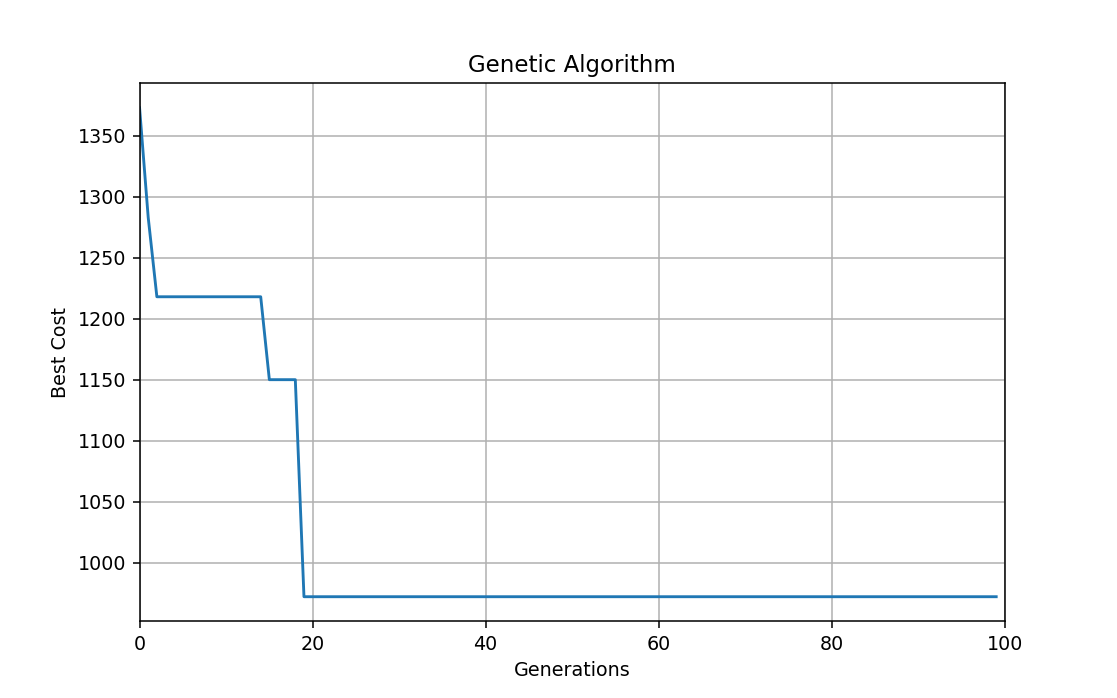

In [28]:
display_graph(maxit, out)